Copyright (c) 2025 Graphcore Ltd. All rights reserved.

# Code Examples

Code snippets, validated against the `weight_formats` library code.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
import torch

import weight_formats.quantisation
import weight_formats.sensitivity
import plot_utils

matplotlib.rcParams.update(
    {
        "axes.spines.top": False,
        "axes.spines.right": False,
        "legend.edgecolor": "none",
        "legend.fontsize": "11",
        "lines.markersize": 3,
    }
)

### `crd_normal`

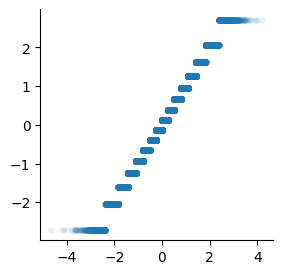

In [2]:
def crd_normal():
    from math import sqrt  # IGNORE
    b = 4
    p = torch.linspace(0, 1, 2**b + 2)
    Q = torch.tensor(scipy.stats.norm.ppf(p[1:-1], scale=sqrt(3)))

    def quantise(x): return torch.bucketize(x, (Q[1:] + Q[:-1]) / 2)
    def dequantise(i): return Q[i]
    # IGNORE
    return Q, quantise, dequantise  # IGNORE

# Checks
Q, quantise, dequantise = crd_normal()
X = torch.randn(2**16, generator=torch.Generator().manual_seed(100))
fmt = weight_formats.quantisation.crd_normal(4, mode="symmetric")
torch.testing.assert_close(torch.tensor(fmt.values), Q)
torch.testing.assert_close(fmt.quantise(X), dequantise(quantise(X)).float())
_, ax = plt.subplots(figsize=(3, 3))
ax.scatter(X, dequantise(quantise(X)), s=20, alpha=0.1, linewidths=0)

plot_utils.save_code(crd_normal)

### `crd_laplace`

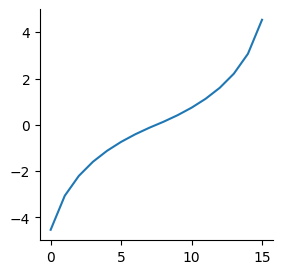

In [3]:
def crd_laplace():
    from math import sqrt  # IGNORE
    b = 4
    p = torch.linspace(0, 1, 2**b + 2)
    Q = torch.tensor(scipy.stats.laplace.ppf(p[1:-1], scale=3/sqrt(2)))
    # IGNORE
    return Q  # IGNORE

torch.testing.assert_close(
    crd_laplace(), torch.tensor(weight_formats.quantisation.crd_laplace(4, "symmetric").values))

_, ax = plt.subplots(figsize=(3, 3))
ax.plot(crd_laplace())

plot_utils.save_code(crd_laplace)

### `crd_t`

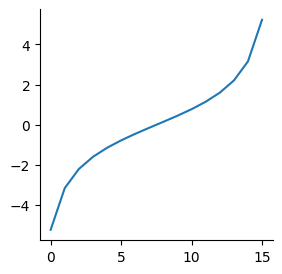

In [4]:
def crd_t():
    from math import sqrt  # IGNORE
    b, df = 4, 7
    p = torch.linspace(0, 1, 2**b + 2)
    Q = torch.tensor(scipy.stats.t.ppf(p[1:-1], (df-2)/3, scale=sqrt(3)))
    # IGNORE
    return Q  # IGNORE

torch.testing.assert_close(
    crd_t(), torch.tensor(weight_formats.quantisation.crd_t(4, 7, "symmetric").values))

_, ax = plt.subplots(figsize=(3, 3))
ax.plot(crd_t())

plot_utils.save_code(crd_t)

### `crd_block_normal`

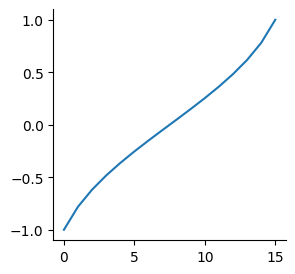

In [5]:
def crd_block_normal():
    from math import log, pi, sqrt  # IGNORE
    b, block_size = 4, 64
    p = torch.linspace(0, 1, 2**b)
    scale = sqrt(3 / (2 * log(block_size/pi)))
    Q = torch.tensor(scipy.stats.truncnorm.ppf(p, -1/scale, 1/scale, scale=scale))
    return Q  # IGNORE

torch.testing.assert_close(
    crd_block_normal(), torch.tensor(weight_formats.quantisation.crd_block_normal(4, 64).values))
_, ax = plt.subplots(figsize=(3, 3))
ax.plot(crd_block_normal())

plot_utils.save_code(crd_block_normal)

### `crd_block_laplace`

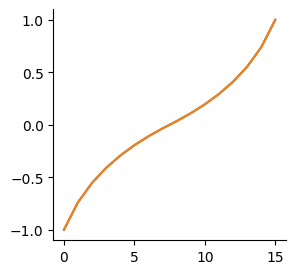

In [6]:
def crd_block_laplace():
    from math import log  # IGNORE
    # IGNORE
    def trunclaplace_ppf(q, x0, x1, scale):
        c0, c1 = scipy.stats.laplace.cdf([x0*scale, x1*scale], scale=scale)
        return scipy.stats.laplace.ppf(c0 + (c1-c0)*q, scale=scale)

    b, block_size = 4, 64
    p = torch.linspace(0, 1, 2**b)
    scale = 3 / (0.57721566 + log(block_size))
    Q = torch.tensor(trunclaplace_ppf(p, -1/scale, 1/scale, scale=scale))
    return Q  # IGNORE

torch.testing.assert_close(
    crd_block_laplace().float(), torch.tensor(weight_formats.quantisation.crd_block_laplace(4, 64).values))
_, ax = plt.subplots(figsize=(3, 3))
ax.plot(crd_block_laplace())
ax.plot(weight_formats.quantisation.crd_block_laplace(4, 64).values)

plot_utils.save_code(crd_block_laplace)

### `crd_block_t`

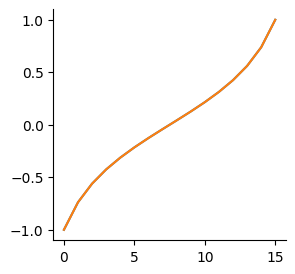

In [7]:
def crd_block_t():
    from math import log, pi, sqrt  # IGNORE
    def trunct_ppf(q, df, x0, x1, scale):
        c0, c1 = scipy.stats.t.cdf([x0*scale, x1*scale], df, scale=scale)
        return scipy.stats.t.ppf(c0 + (c1-c0)*q, df, scale=scale)

    b, block_size, df = 4, 64, 7
    p = torch.linspace(0, 1, 2**b)
    scale = (2*log(block_size/pi))**((3-df)/(2*df)) * block_size**(-1/df) * sqrt(3)
    Q = torch.tensor(trunct_ppf(p, (df-2)/3, -1/scale, 1/scale, scale=scale))
    return Q  # IGNORE

torch.testing.assert_close(
    crd_block_t(), torch.tensor(weight_formats.quantisation.crd_block_t(4, 64, 7).values))
_, ax = plt.subplots(figsize=(3, 3))
ax.plot(crd_block_t())
ax.plot(weight_formats.quantisation.crd_block_t(4, 64, 7).values)

plot_utils.save_code(crd_block_t)

### `fisher_wrapper`

In [8]:
def fisher_wrapper():
    class FisherWrappedLinear(torch.nn.Module):
        def __init__(self, m: torch.nn.Linear):
            super().__init__()
            self.m = m
            self.gW2 = torch.zeros_like(self.m.weight, dtype=torch.float32)

        def forward(self, x):
            y = self.m(x)
            y.requires_grad_(True).register_hook(
                lambda gy: self.gW2.addmm_(
                    gy.detach().flatten(0, -2).float().square().T,
                    x.detach().flatten(0, -2).float().square(),
                ) is None or None
            )
            return y
    return FisherWrappedLinear  # IGNORE

torch.manual_seed(1)
model = torch.nn.Linear(10, 20, bias=False)

x, grad_y = torch.randn(50, 10), torch.randn(50, 20)
wrapper = fisher_wrapper()(model)
wrapper(x).backward(grad_y)
reference_wrapper = weight_formats.sensitivity.LinearWrapper(model)
reference_wrapper(x).backward(grad_y)
torch.testing.assert_close(wrapper.gW2, reference_wrapper.grad_weight_sq.sum())

plot_utils.save_code(fisher_wrapper)